In [78]:
from pytube import YouTube
import os
import subprocess
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable 
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import time
from torch.optim.lr_scheduler import ExponentialLR
import sklearn.metrics as metrics
from torchinfo import summary
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Функции, используемые в проекте

In [2]:
def download_audio(video_paths: str, audio_save_paths: str, to_mp3: bool=True):
    '''
    Функция загружает все аудиодорожки из спика и приводит их формату mp3
    Входные параметры:
    video_paths: str - путь к файлу со списком видео
    audio_save_paths: str - путь к папке, куда сохранять аудио
    to_mp3: bool=True - флаг преобразования к mp3
    '''
    with open(video_paths) as f:
        links = f.readlines()
    links = [x.replace('\n', '') for x in links]
    for link in links:
        yt=YouTube('https://www.youtube.com/watch?v=' + link)
        try:
            t=yt.streams.filter(only_audio=True)
            t[0].download(audio_save_paths)
            if to_mp3:
                default_filename = t[0].default_filename
                subprocess.run(['ffmpeg', '-i', os.path.join(audio_save_paths, default_filename),
                                os.path.join(audio_save_paths + '/mp3', link+'.mp3')])
        except:
            continue

In [3]:
def create_spec_dataset(speech_labels_paths: str, path_specs: str, path_to_audio_dir: str=None, 
                        delimeter: str=',', abs_path_to_audio: bool=False, format_audio: str='mp3'):
    '''
    Функция принимает на вход пути ко всем аудио датасета и преобразует их к спектрограммам
    Входные данные:
    speech_labels_paths: str - путь к датасету AVA формата
    path_specs: str - путь к папке, куда сохранять спектрограммы
    path_to_audio_dir: str=None - путь к папке с аудио файлами, если в датасете указан не абсолютный путь
    delimeter: str=',' - разделитель параметров в датасете
    abs_path_to_audio: bool=False - флаг, указывающий абсолютный ли путь к данным в датасете
    format_audio: str='mp3' - формат данных
    '''
    with open(speech_labels_paths) as f:
        speech_labels = f.readlines()
    speech_labels = [x.replace('\n', '') for x in speech_labels]

    label_to_num = {
        'NO_SPEECH':0, 
        'CLEAN_SPEECH':1,
        'SPEECH_WITH_MUSIC':2, 
        'SPEECH_WITH_NOISE':3
    }
    
    i = 0
    labels = []
    while i < len(speech_labels):  
        audio = speech_labels[i].split(delimeter)[0]
        if not abs_path_to_audio:
            path_to_audio = '{0}/{1}.{2}'.format(path_to_audio_dir, audio, format_audio)
        else:
            path_to_audio = audio
            audio = path_to_audio.split('/')[-1].split('.')[0]
        try:
            waveform, sample_rate = torchaudio.load(path_to_audio)
            print(path_to_audio)
        except:
            i += 1
            continue
        waveform = torch.mean(waveform, dim=0).unsqueeze(0)
        j = 0
        while True:
            speech_label_split = speech_labels[i].split(delimeter)
            second_start = float(speech_label_split[1])
            second_end = float(speech_label_split[2])
            label = speech_label_split[3]
            while second_end - second_start > 0.32:
                specgram = torchaudio.transforms.MelSpectrogram(sample_rate = sample_rate, win_length=441, 
                                                                n_mels=32, power=1, hop_length=441, n_fft=441)(waveform[0][int(second_start*sample_rate):int(second_start*sample_rate) + 14112])
                data = specgram.log2().detach().numpy()
                np.save(path_specs + '/{0}_{1}'.format(audio, str(j)), data)
                labels.append([path_specs + '/{0}_{1}.npy'.format(audio, str(j)), label_to_num[label]])
                j += 1
                second_start += 0.32
            i += 1
            if speech_labels[i].split(delimeter)[0] != audio:
                break
    return np.array(labels)

In [19]:
def create_train_test_dataset(data: str, test_size: float=0.2):
    '''
    Функция принимает на вход файл с указанием путей ко всем спектрограммам и их меткам
    Входные данные:
    data: str - список путей к спектрограммам и их меток
    test_size: float=0.2 - доля тестовой выборки в общем количестве данных
    '''
    np.random.shuffle(data)
    df = pd.DataFrame(data)
    df = df.rename(columns={0: 'spec_paths', 1: 'labels'})
    df.loc[:, 'spec_paths'] += '.npy'
    m = df.loc[:, 'labels'] == '0'
    df.loc[m, 'labels'] = 0
    m = df.loc[:, 'labels'] != 0
    df.loc[m, 'labels'] = 1
    test_df = df.loc[:int(df.shape[0]*test_size)].reset_index()
    train_df = df.loc[int(df.shape[0]*test_size):].reset_index().drop('index', axis=1)
    return train_df, test_df

In [28]:
def visualize_spec(df: pd.DataFrame, idx: int):
    '''
    Функция принимает на вход датасет и индекс и визуализирует соответствующую спектрограмму
    Входные данные:
    df: pd.DataFrame - датафрейм с данными
    idx: int - индекс визуализируемого элемента
    '''
    im = np.load(df.iloc[idx, 0])
    plt.imshow(im, cmap='jet')
    plt.show()
    print(df.iloc[i, 1])

In [6]:
def get_mean_std(research_data_loader: DataLoader):
    '''
    Функция принимает на вход исследуемый датасет и вычисляет по нему среднее и СКО
    Входные данные:
    research_data_loader: DataLoader - датасет, приведенный к формату DataLoader
    '''
    nimages = 0
    mean = 0.
    std = 0.
    for batch in research_data_loader:
        nimages += 1
        mean += batch[0].mean()
        std += batch[0].std()

    mean /= nimages
    std /= nimages
    return float(mean), float(std)

In [66]:
def test_result(model, test_data_loader: DataLoader):
    '''
    Функция принимает на вход модель и тестовый датасет и вычисляет по нему значение метрики и предсказанные 
    значения
    Входные данные:
    model - обученная модель
    test_data_loader: DataLoader - тестовый датасет, приведенный к формату DataLoader
    '''
    model.eval()
    test_metrics = []
    test_losses = []
    result = {}
    y_true = []
    y_proba = []
    for batch_idx, data in enumerate(test_data_loader):
        inputs = data[0]
        target = data[1]
        outputs = model(inputs)        
        loss = criterion(outputs[:, 0], target.to(torch.float32))
        test_losses.append(loss.item())
        y_true.append(np.array(target.detach().numpy()))
        y_proba.append(np.array(outputs[:,0].detach().numpy()))

    y_true = np.concatenate(np.array(y_true), axis=0)
    y_proba = np.concatenate(np.array(y_proba), axis=0)

    test_loss    = np.mean(test_losses)
    test_metric  = metric(y_true, y_proba)
    result['test_loss'] = test_loss
    result['test_metric'] = test_metric
    print(result)
    return y_true, y_proba

In [60]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    '''
    Функция принимает на вход предсказзные моделью значения и истинные метки и строит изменения f1, precision, 
    recall при изменяющемся значении порога от 0.1 до 0.9
    Входные данные:
    y_predicted_probs - предсказанные моделью значения
    y_true_labels - истинные значения
    '''
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Сlass 0', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Class 1', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [61]:
def labels_pred(pred_proba, threshold):
    '''
    Функция принимает на вход предсказзные моделью значения и значение порога и преобразует значения
    к бинарной классификации
    Входные данные:
    pred_proba - предсказанные моделью значения
    threshold - пороговое значение
    '''
    _labels_pred = np.array(list(map(lambda x: 0 if x<threshold else 1, pred_proba)))
    return _labels_pred

def report(y_true, y_prob, threshold=0.4):
    '''
    Функция принимает на вход предсказзные моделью значения, истинные значения и значение порога
    и получает матрицу ошибок для заданного порога
    Входные данные:
    y_true - истинные значения
    y_prob - предсказанные моделью значения
    threshold=0.4 - пороговое значение
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, labels_pred(y_prob, threshold)).ravel()
    print(classification_report(y_true, labels_pred(y_prob, threshold)))
    print('---------------')
    print('Матрица ошибок:')
    print(confusion_matrix(y_true, labels_pred(y_prob, threshold)))
    print('---------------')
    print(f'Правильно предсказано 0: {tn}')
    print(f'Правильно предсказано 1: {tp}')
    print(f'Ложноотрицательных (FN, ош2р, пропуск события): {fn}')
    print(f'Ложноположительных (FP, ош1р, ложная  тревога): {fp}')
    print(f'Всего ошибок: {fp+fn}')

In [96]:
def plot_precision_recall(y_true, y_proba):
    '''
    Функция принимает на вход предсказзные моделью значения и истинные значения и строит PR кривую с f1 изолиниями
    Входные данные:
    y_true - истинные значения
    y_prob - предсказанные моделью значения
    '''
    _, ax = plt.subplots(figsize=(7, 7))

    prec, recall, _ = precision_recall_curve(y_true, y_proba)
    ax.plot(recall, prec, linewidth=2, color='r')

    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        ax.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.5)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([min(prec), 1.01])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.grid()

# Классы, используемые в проекте

In [7]:
class AVADataset(Dataset):
    '''
    Конструктор класса принимает датафрейм с путями к спектрограммам, среднее и СКО, вычисленные по
    исследовательским данным.
    Возвращает стандратизованную спектрограмму формы (1, 32, 32) и метку ее класса
    '''
    def __init__(self, dataframe: pd.DataFrame, mean: float, std: float):
        self.spec_paths = dataframe['spec_paths']
        self.labels = dataframe['labels']
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return ((np.load(self.spec_paths[idx])-self.mean)/self.std).reshape(-1,32,32), self.labels[idx]

In [8]:
class ModelVad(nn.Module):
    '''
    Класс, описывающий модель VAD
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(6*6*128, 64)
        self.bilstm = nn.LSTM(1, hidden_size=128, bidirectional=True, batch_first = True)
        self.fc2 = nn.Linear(256, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,6*6*128)
        x = F.relu(self.fc1(x))
        x = x.view(-1,64,1)
        x, (h, c) = self.bilstm(x)
        x = torch.cat((h[0,:,:], h[1,:,:]), 1)
        x = x.view(-1,256)
        x = self.fc2(x)
        x = F.softmax(x, -1)
        return x

In [50]:
class ModelWrapper(nn.Module):
    '''
    Класс для работы с моделью
    '''
    def __init__(self, model: object):
        super(ModelWrapper, self).__init__()
        self.model = model

        
    def forward(self, input_data):
        output_data = self.model(input_data)
        return output_data
    
    
    def fit(self, criterion: object, metric: object, optimizer: object, scheduler: object,
                  train_data_loader: DataLoader, valid_data_loader: DataLoader=None, 
                  epochs: int=1, verbose: int=5):        
        '''Метод для обучения модели
        Входные параметры:
        criterion: object - объект для вычисления loss
        metric: object - объект для вычисления метрики качества
        optimizer: object - оптимизатор
        scheduler: object - объект для изменения lr в ходе обучения
        train_data_loader: DataLoader - загрузчик данных для обучения
        valid_data_loader: DataLoader - загрузчик данных для валидации
        epochs: int - количество эпох обучения
        verbose: int - вывод информации через каждые verbose итераций
        Возвращаемые значения:
        result: dict - словарь со значениями loss при тренировке, валидации и метрики при валидации 
        для каждой эпохи'''
        self.optimizer = optimizer
        epoch_train_losses = []
        epoch_valid_losses = []
        epoch_valid_metrics = []
        result = {}
        
        for epoch in range(epochs):
            self.model.train()
            time1 = time.time()
            running_loss = 0.0
            train_losses = []
            
            for batch_idx, data in enumerate(train_data_loader):

                inputs, target = data[0], data[1]
                optimizer.zero_grad()
                outputs = self.model(inputs)

                loss = criterion(outputs[:,0], target.to(torch.float32))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                train_losses.append(loss.item())
                if (batch_idx+1) % verbose == 0:
                    print(f'Train Epoch: {epoch+1}, Loss: {(running_loss/verbose):.6f}, ', end="")
                    print(f'Learning rate: {scheduler.get_last_lr()[0]}')
                    time2 = time.time()
                    print(f'Spended time for {verbose} batches (total: {batch_idx})({int((verbose*data[0].shape[0]))} images', end="") 
                    print(f': {(time2-time1):.6f} sec')
                    
                    time1 = time.time()
                    running_loss = 0.0
                if (batch_idx+1) % 3000 == 0:
                    train_loss = np.mean(train_losses)
                    if valid_data_loader != None:
                        valid_result = self.valid(criterion, metric, valid_data_loader)
                        valid_loss = valid_result['valid_loss']
                        valid_metric = valid_result['valid_metric']

                        print('='*80)
                        print(f'Epoch {epoch+1}, train loss: {(train_loss):.6f}, valid loss: {(valid_loss):.6f}, ', end="")
                        print(f'valid metric: {(valid_metric):.6f}')
                        print('='*80)
                    else:
                        print('='*80)
                        print(f'Epoch {epoch+1}, train loss: {(train_loss):.6f}')
                        print('='*80)
                        valid_loss = None
                        valid_metric = None

            train_loss = np.mean(train_losses)
            scheduler.step()
            
            if valid_data_loader != None:
                valid_result = self.valid(criterion, metric, valid_data_loader)
                valid_loss = valid_result['valid_loss']
                valid_metric = valid_result['valid_metric']

                print('='*80)
                print(f'Epoch {epoch+1}, train loss: {(train_loss):.6f}, valid loss: {(valid_loss):.6f}, ', end="")
                print(f'valid metric: {(valid_metric):.6f}')
                print('='*80)
            else:
                print('='*80)
                print(f'Epoch {epoch+1}, train loss: {(train_loss):.6f}')
                print('='*80)
                valid_loss = None
                valid_metric = None
            epoch_train_losses.append(train_loss)
            epoch_valid_losses.append(valid_loss)
            epoch_valid_metrics.append(valid_metric)
        
        result['epoch_train_losses'] = epoch_train_losses
        result['epoch_valid_losses'] = epoch_valid_losses
        result['epoch_valid_metrics'] = epoch_valid_metrics
        
        return result
    
    
    def valid(self, criterion: object, metric: object, valid_data_loader: DataLoader):
        '''Метод для валидации модели
        Входные параметры:
        criterion: object - объект для вычисления loss
        metric: object - объект для вычисления метрики качества
        valid_data_loader: DataLoader - загрузчик данных для валидации
        Возвращаемые значения:
        result: dict - словарь со значениями loss и метрики при валидации'''
        self.model.eval()
        valid_metrics = []
        valid_losses = []
        result = {}
        y_true = []
        y_proba = []
        for batch_idx, data in enumerate(valid_data_loader):
            inputs = data[0]
            target = data[1]
            outputs = self.model(inputs)        
            loss = criterion(outputs[:, 0], target.to(torch.float32))
            valid_losses.append(loss.item())
            y_true.append(np.array(target.detach().numpy()))
            y_proba.append(np.array(outputs[:,0].detach().numpy()))
        y_true = np.concatenate(np.array(y_true), axis=0)
        y_proba = np.concatenate(np.array(y_proba), axis=0)
        valid_loss    = np.mean(valid_losses)
        valid_metric  = metric(y_true, y_proba)
        result['valid_loss'] = valid_loss
        result['valid_metric'] = valid_metric
        self.model.train()
        return result
    
    
    def save(self, path_to_save: str = './VAD_model.pth'):
        torch.save(self.model.state_dict(), path_to_save)


    def load(self, path_to_model: str = './VAD_model.pth'):
        self.model.load_state_dict(torch.load(path_to_model))

# Пайплайн данных

### Загрузка аудио

In [ ]:
download_audio('/Users/igorfrolkin/Downloads/ava_video_list_v1.0.txt','/Users/igorfrolkin/Downloads/ava_sounds')

### Подготовка спектрограмм

In [ ]:
labels = create_spec_dataset('/Users/igorfrolkin/Downloads/ava_speech_labels_v1.csv',
                    '/Users/igorfrolkin/Downloads/ava_spec',
                    '/Users/igorfrolkin/Downloads/ava_sounds/mp3')

/Users/igorfrolkin/Downloads/ava_sounds/mp3/5BDj0ow5hnA.mp3
/Users/igorfrolkin/Downloads/ava_sounds/mp3/5BDj0ow5hnA.mp3
/Users/igorfrolkin/Downloads/ava_sounds/mp3/5BDj0ow5hnA.mp3


### Подготовка датасетов для обучения и тестов

In [20]:
train_df, test_df = create_train_test_dataset(labels)
train_df.head()

,spec_paths,labels
0,/Users/igorfrolkin/Downloads/ava_spec/zR725veL...,1
1,/Users/igorfrolkin/Downloads/ava_spec/IKdBLciu...,0
2,/Users/igorfrolkin/Downloads/ava_spec/4ZpjKfu6...,1
3,/Users/igorfrolkin/Downloads/ava_spec/kMy-6Rto...,1
4,/Users/igorfrolkin/Downloads/ava_spec/xO4ABy2i...,0


In [21]:
print(f'Images for train: {train_df.shape[0]}, images for test: {test_df.shape[0]}')

Images for train: 210761, images for test: 52691


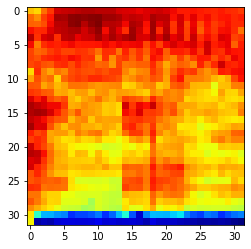

1


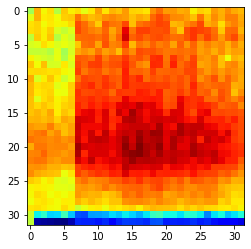

0


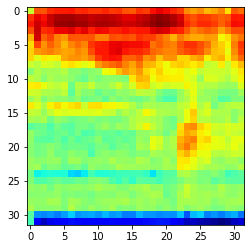

1


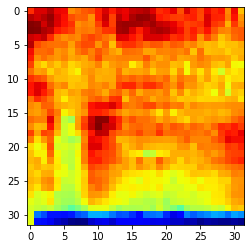

1


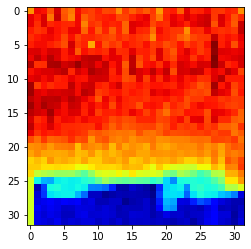

0


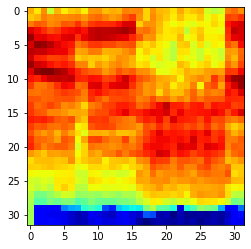

1


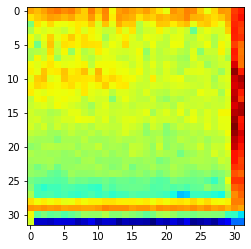

1


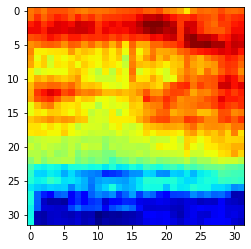

1


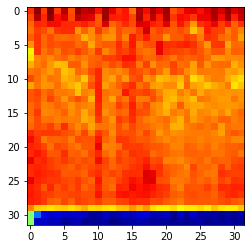

0


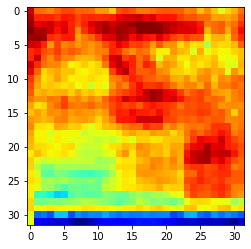

1


In [29]:
for i in range(0,10):
    visualize_spec(train_df, i)

### Вычисление параметров стандартизации данных

In [33]:
research_dataset = AVADataset(train_df, 0, 1)
research_data_loader = DataLoader(research_dataset, batch_size=32, shuffle=True, num_workers=2)

In [34]:
mean, std = get_mean_std(research_data_loader)

### Создание dataloaders для всех датасетов

In [48]:
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

#mean=-2.4525
#std=3.9360
train_dataset = AVADataset(train_df, mean, std)
valid_dataset = AVADataset(valid_df, mean, std)
test_dataset = AVADataset(test_df, mean, std)

train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_data_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=2)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

print(f'Images for train: {train_df.shape[0]}, images for validation: {valid_df.shape[0]}, images for test: {test_df.shape[0]}')

Images for train: 170715, images for validation: 18969, images for test: 52691


### Создание модели

In [51]:
model = ModelVad()
model_wrapper = ModelWrapper(model=model)
summary(model_wrapper.model, input_size=(32, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ModelVad                                 --                        --
├─Conv2d: 1-1                            [32, 32, 28, 28]          832
├─MaxPool2d: 1-2                         [32, 32, 14, 14]          --
├─Conv2d: 1-3                            [32, 128, 12, 12]         36,992
├─MaxPool2d: 1-4                         [32, 128, 6, 6]           --
├─Linear: 1-5                            [32, 64]                  294,976
├─LSTM: 1-6                              [32, 64, 256]             134,144
├─Linear: 1-7                            [32, 2]                   514
Total params: 467,458
Trainable params: 467,458
Non-trainable params: 0
Total mult-adds (M): 475.51
Input size (MB): 0.13
Forward/backward pass size (MB): 15.35
Params size (MB): 1.87
Estimated Total Size (MB): 17.35

In [52]:
learning_rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = ExponentialLR(optimizer, gamma=0.95)
metric = metrics.roc_auc_score
criterion = torch.nn.BCELoss()

### Обучение

In [ ]:
result_train = model_wrapper.fit(criterion,
             metric,
             optimizer,
             scheduler,
             train_data_loader,
             valid_data_loader,
             epochs=4,
             verbose=10)

In [103]:
model_wrapper.save('/Users/igorfrolkin/Downloads/vad_model_4.pth')

# После 5 эпох обучения

In [69]:
result_train

{'epoch_train_losses': [0.42019958782385974,
  0.3800158992563326,
  0.3710439297900428,
  0.3658094008684494,
  0.36161703397821016],
 'epoch_valid_losses': [0.3948135840601302,
  0.3808978918129437,
  0.37604399711446457,
  0.37475262421480116,
  0.3584223410230865],
 'epoch_valid_metrics': [0.8975697688456044,
  0.9029164369011554,
  0.9093207757868048,
  0.908645613076132,
  0.9149079481505824]}

In [ ]:
y_true, y_proba = test_result(model, test_data_loader)

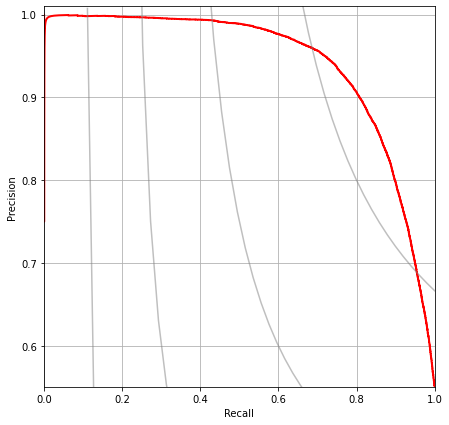

In [97]:
plot_precision_recall(y_true, y_proba)

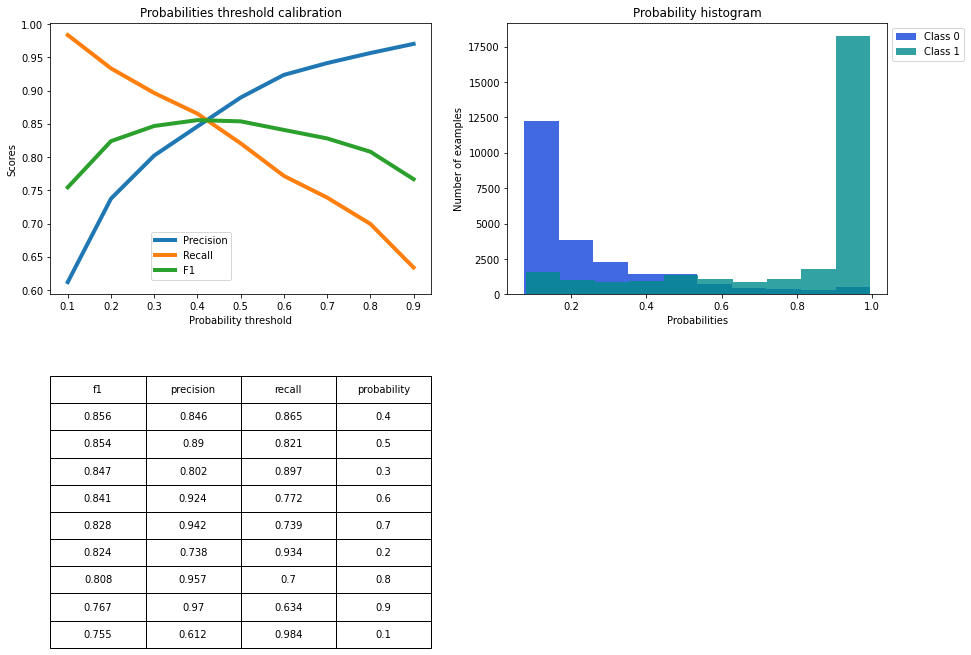

In [79]:
show_proba_calibration_plots(y_proba, y_true)

In [80]:
report(y_true, y_proba, 0.4)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     23711
           1       0.85      0.87      0.86     28980

    accuracy                           0.84     52691
   macro avg       0.84      0.84      0.84     52691
weighted avg       0.84      0.84      0.84     52691

---------------
Матрица ошибок:
[[19155  4556]
 [ 3899 25081]]
---------------
Правильно предсказано 0: 19155
Правильно предсказано 1: 25081
Ложноотрицательных (FN, ош2р, пропуск события): 3899
Ложноположительных (FP, ош1р, ложная  тревога): 4556
Всего ошибок: 8455


# После 10 эпох обучения

In [104]:
result_train

{'epoch_train_losses': [0.35466399182196295,
  0.3578440760828785,
  0.3561028981611007,
  0.34922709425364906],
 'epoch_valid_losses': [0.364269640956319,
  0.36281348793794094,
  0.3644556462588841,
  0.354744628071785],
 'epoch_valid_metrics': [0.9129074445010021,
  0.9120592305508752,
  0.9125305574706409,
  0.9172071413716094]}

In [105]:
y_true, y_proba = test_result(model, test_data_loader)

{'test_loss': 0.3543911971463966, 'test_metric': 0.9179922672191441}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


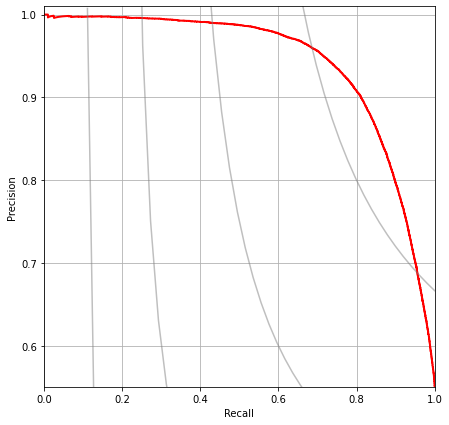

In [106]:
plot_precision_recall(y_true, y_proba)

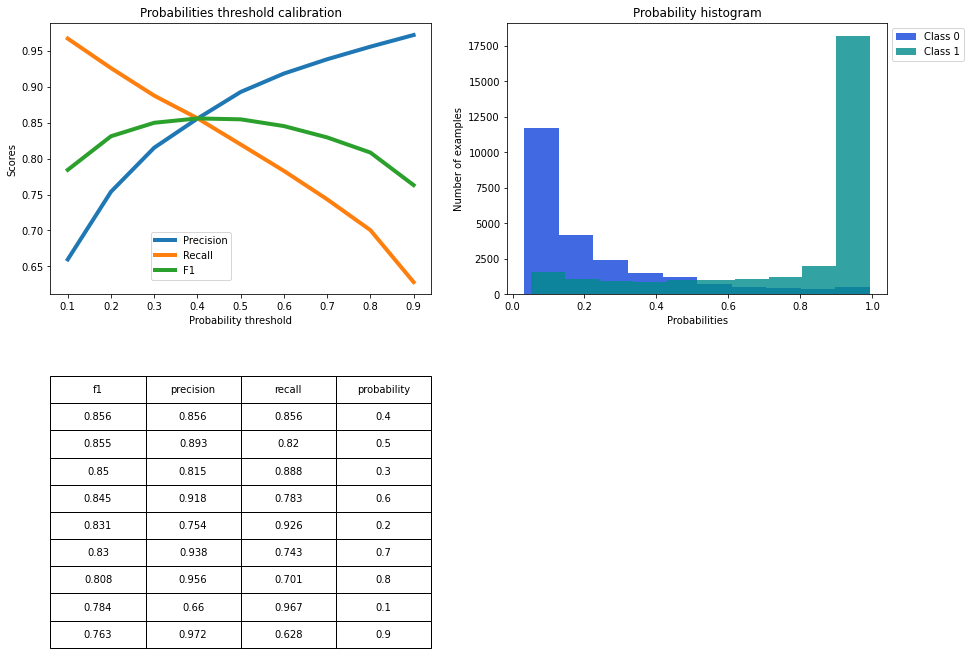

In [107]:
show_proba_calibration_plots(y_proba, y_true)

In [125]:
report(y_true, y_proba, 0.45)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83     23711
           1       0.88      0.84      0.86     28980

    accuracy                           0.85     52691
   macro avg       0.84      0.85      0.84     52691
weighted avg       0.85      0.85      0.85     52691

---------------
Матрица ошибок:
[[20264  3447]
 [ 4691 24289]]
---------------
Правильно предсказано 0: 20264
Правильно предсказано 1: 24289
Ложноотрицательных (FN, ош2р, пропуск события): 4691
Ложноположительных (FP, ош1р, ложная  тревога): 3447
Всего ошибок: 8138
